In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import dendrogram

## 1. Read the data

In [2]:
# read the dataset
retail_df = pd.read_csv("./Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 2. Clean the data

In [5]:
# Checking the number of missing rows in each columns

retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
round(retail_df.isnull().sum()/len(retail_df) * 100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
# Dropping the missing rows
retail_df = retail_df.dropna()
retail_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
retail_df.shape

(406829, 8)

In [9]:
retail_df['amount'] = retail_df['Quantity'] * retail_df['UnitPrice']

retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## 3. Data preperation for modeling

- R (Recency): No. of days since last purchase
- F (Frequency): No of transactions done in the last one year
- M (Monetry): Total amount of transactions (Revenue contributed by the customer)

In [10]:
# Monetary contributed by the customer
grouped_monetry = retail_df.groupby('CustomerID').amount.sum().reset_index()
grouped_monetry

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


In [11]:
# Frequency
grouped_frequency = retail_df.groupby('CustomerID').InvoiceNo.count().reset_index()
grouped_frequency.columns = ['CustomerID', 'frequency']
grouped_frequency

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [12]:
# Merging monetary and frequency

grouped_df = pd.merge(grouped_monetry, grouped_frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [13]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [14]:
# Convert InvoiceDate to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [15]:
max_date = retail_df.InvoiceDate.max()

max_date

Timestamp('2011-12-09 12:50:00')

In [16]:
retail_df['date_diff'] = max_date - retail_df['InvoiceDate']

retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,date_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [17]:
# Creating the recency column
grouped_last_purchase = retail_df.groupby('CustomerID').date_diff.min().reset_index()

grouped_last_purchase

,CustomerID,date_diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [18]:
grouped_df = pd.merge(grouped_df, grouped_last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency','recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [19]:
grouped_df['recency'] = grouped_df.recency.dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [20]:
grouped_df.describe()

,CustomerID,amount,frequency,recency
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,1898.459701,93.053294,91.047118
std,1722.390705,8219.345141,232.471608,100.765435
min,12346.000000,-4287.630000,1.000000,0.000000
25%,13812.750000,293.362500,17.000000,16.000000
50%,15300.500000,648.075000,42.000000,49.000000
75%,16778.250000,1611.725000,102.000000,142.000000
max,18287.000000,279489.020000,7983.000000,373.000000


#### Below steps needs to be taken care of before injecting data into model

1. Outlier treatment
2. Scaling the values - StandardScaling or MinMaxScaler

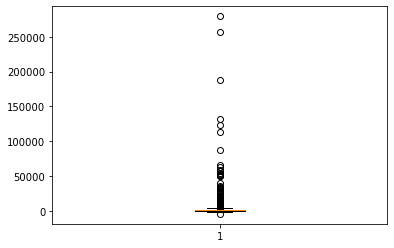

In [21]:
# 1. Outlier treatment

"""
There are two types of outliers

1. Statistical outlier
    Ex: Defined by percentile say more than 95 percentile, I will consider all other values as an outlier
    
2. Domain specific outlier
    
Over here, we are not removing any outliers and going ahead with what we have as we'd want to consider the
outlier/extreme customers as well.
"""


plt.boxplot(grouped_df['amount'])
plt.show()

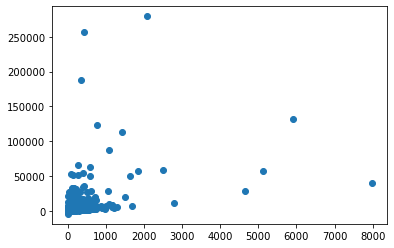

In [22]:
plt.scatter(grouped_df['frequency'], grouped_df['amount'])

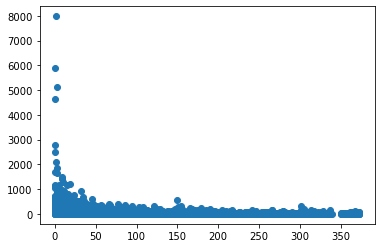

In [23]:
plt.scatter(grouped_df['recency'], grouped_df['frequency'])

In [25]:
# Outlier treatment for amount
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3+1.5*IQR)]

# Outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3-Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3+1.5*IQR)]


# Outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3-Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3+1.5*IQR)]

In [26]:
rfm_df = grouped_df[['amount', 'frequency', 'recency']]
rfm_df.head()

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [27]:
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)

rfm_df_scaled.shape

(4293, 3)

In [28]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=['amount', 'frequency', 'recency'])
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## 4. Modeling

In [29]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [30]:
kmeans.labels_

array([0, 3, 1, ..., 0, 1, 1], dtype=int32)

### 4.1 Optimal no of cluster

1. Elbow-curve/Sum of Square Distances technique
2. Silhouette technique

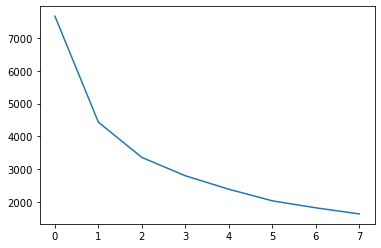

In [31]:
ssd = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)
# plt.xticks(np.arange(2, 10), max(11), 1.0)
plt.show()

In [32]:
for k in range(2, 10):
    
    # Initialze the cluster
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    # Calculate silhoutte score
    sil_score = silhouette_score(rfm_df_scaled, kmeans.labels_)
    print("For n_cluster={0}, the silhoutte score={1}".format(k, sil_score))

For n_cluster=2, the silhoutte score=0.5415858652525395
For n_cluster=3, the silhoutte score=0.5084896296141937
For n_cluster=4, the silhoutte score=0.4776896767524438
For n_cluster=5, the silhoutte score=0.466103965297297
For n_cluster=6, the silhoutte score=0.4170584389874765
For n_cluster=7, the silhoutte score=0.4154546320653256
For n_cluster=8, the silhoutte score=0.3994762239155064
For n_cluster=9, the silhoutte score=0.3704320562021219


In [33]:
# We will be creating 3 clusters
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [34]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1], dtype=int32)

In [35]:
rfm_df_scaled['cluster'] = kmeans.labels_
rfm_df.head()
print(len(kmeans.labels_))
print(len(rfm_df_scaled))

4293
4293


In [36]:
plt.scatter(grouped_df['recency'], grouped_df['cluster'])

KeyError: 'cluster'

## 5. Cluster Analysis

In [ ]:
sns.boxplot(x='cluster',y='amount', data=rfm_df_scaled)

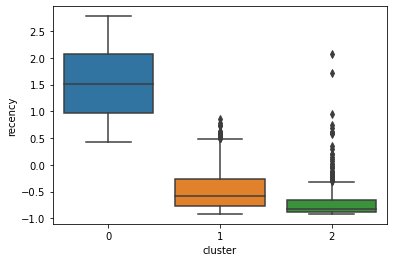

In [37]:
sns.boxplot(x='cluster',y='recency', data=rfm_df_scaled)

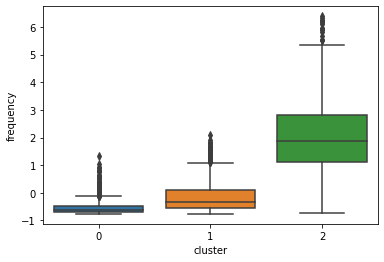

In [38]:
sns.boxplot(x='cluster',y='frequency', data=rfm_df_scaled)

# Hierarchical Clustering

In [39]:
rfm_df_scaled.head()

,amount,frequency,recency,cluster
0,-0.723738,-0.752888,2.301611,0
1,1.731617,1.042467,-0.906466,2
2,0.300128,-0.463636,-0.183658,1
3,0.277517,-0.044720,-0.738141,1
4,-0.533235,-0.603275,2.143188,0


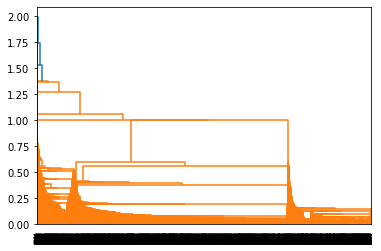

In [40]:
# Single linkage
mergings = linkage(rfm_df_scaled, method='single', metric='euclidean')
dendrogram(mergings)
plt.show()

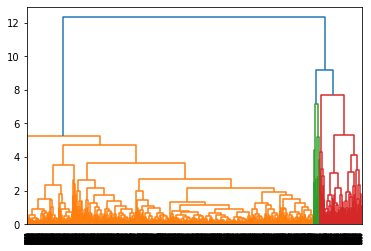

In [41]:
# Complete linkage
mergings = linkage(rfm_df_scaled, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

In [51]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [53]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels

grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_labels
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


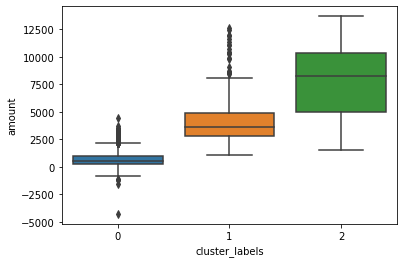

In [56]:
sns.boxplot(x='cluster_labels',y='amount', data=grouped_df)

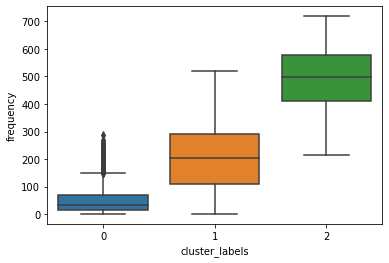

In [57]:
sns.boxplot(x='cluster_labels',y='frequency', data=grouped_df)

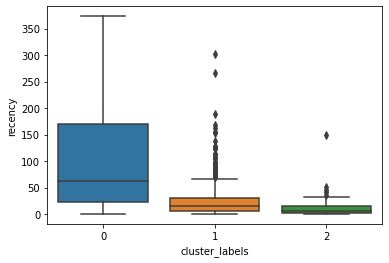

In [58]:
sns.boxplot(x='cluster_labels',y='recency', data=grouped_df)

In [64]:
s1 = pd.Series([6, 1, 2, 4, 5, 11], index='X')
# s2 = pd.Series([0,2,7,6,3,1])
# data_frame = pd.DataFrame([s1], columns=['X', 'Y'])

# data_frame
s1

TypeError: Index(...) must be called with a collection of some kind, 'X' was passed